#  1D Advection Equation

The one-dimensional advection equation describes the transport of a scalar quantity $u(x, t)$ at a constant velocity $ \alpha $:

\begin{equation}
\frac{\partial u}{\partial t} + \alpha \frac{\partial u}{\partial x} = 0
\end{equation}


It represents how a wave or distribution moves without distortion along the $x$ -axis at speed $ \alpha $. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython.display import Video

In [2]:
# Parameters
L = 1.0          # Domain
alpha = 1.0      # advection velocity
N = 500          # number of space points
dx = L / N       # spatial step
x = np.linspace(-L, L, N, endpoint=False)

# CFL
CFL = 0.5                           
dt = CFL * dx / abs(alpha)          # Time step
tf = 3.0                            # Final time
n_steps = int(tf / dt) + 1          # Total number of time steps

# Initial condition: Gaussian pulse 
u0 = np.exp(-100 * (x)**2)

In [3]:
# Runge-Kutta 4 Algorithm
def RK4(ODE, t0, q0, tf, n):
    dt = (tf - t0)/(n-1)
    q = np.zeros([n, len(q0)+1])
    q[0, 0] = t0
    q[0, 1:] = q0
    for i in range(1, n):
        q[i, 0] = q[i-1, 0] + dt
        k1 = dt * ODE(q[i-1, 0], q[i-1, 1:])
        k2 = dt * ODE(q[i-1, 0] + dt/2, q[i-1, 1:] + k1/2)
        k3 = dt * ODE(q[i-1, 0] + dt/2, q[i-1, 1:] + k2/2)
        k4 = dt * ODE(q[i-1, 0] + dt, q[i-1, 1:] + k3)
        q[i, 1:] = q[i-1, 1:] + (k1 + 2*k2 + 2*k3 + k4)/6
    return q

In [4]:
def du1dt(t, u):
    # Centered difference
    # du_i/dt = -α * (u_{i+1} - u_{i-1}) / (2Δx)
    return -alpha * (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)


In [5]:
def du2dt(t, u):
    # Forward difference
    # du_i/dt = -α * (u_{i+1} - u_i) / Δx
    return -alpha * (np.roll(u, -1) - u) / dx


In [6]:
def du3dt(t, u):
    # Backward difference
    # du_i/dt = -α * (u_i - u_{i-1}) / Δx
    return -alpha * (u - np.roll(u, 1)) / dx


In [7]:
def save_advection_animation_1D(x, u_array, t_array, filename="advection_1D.mp4", ylim=(-0.1, 1.1), fps=25):

    fig, ax = plt.subplots()
    line, = ax.plot(x, u_array[0])
    ax.set_ylim(*ylim)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title('1D Advection')

    def update(frame):
        line.set_ydata(u_array[frame])
        ax.set_title(f't = {t_array[frame]:.2f}')
        return line,

    ani = FuncAnimation(fig, update, frames=len(t_array), interval=1000/fps)
    
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    ani.save(filename, writer=writer)

    plt.close(fig)  # prevent showing static plot
    return Video(filename)

In [8]:
# Time integration using RK4 centered difference

u_c = np.zeros((n_steps, N))
u_c[0] = u0
sol_centered = RK4(du1dt, 0, u0, tf, n_steps)
t_c = sol_centered[:, 0]
u_c = sol_centered[:, 1:]

save_advection_animation_1D(x, u_c, t_c, filename="rk4_centered.mp4")



In [9]:
# Time integration using RK4 Forward difference
u_f = np.zeros((n_steps, N))
u_f[0] = u0
sol_forward  = RK4(du2dt, 0, u0, tf, n_steps)
t_f = sol_forward[:, 0]
u_f = sol_forward[:, 1:]
save_advection_animation_1D(x, u_f, t_f, filename="rk4_forward.mp4")



/tmp/ipykernel_188516/1255213737.py:4: RuntimeWarning: overflow encountered in divide
  return -alpha * (np.roll(u, -1) - u) / dx
/tmp/ipykernel_188516/1255213737.py:4: RuntimeWarning: invalid value encountered in subtract
  return -alpha * (np.roll(u, -1) - u) / dx


In [10]:
# Time integration using RK4 and Backward difference
u_b = np.zeros((n_steps, N))
u_b[0] = u0
sol_backward = RK4(du3dt, 0, u0, tf, n_steps)
t_b = sol_backward[:, 0]
u_b = sol_backward[:, 1:]
save_advection_animation_1D(x, u_b, t_b, filename="rk4_backward.mp4")


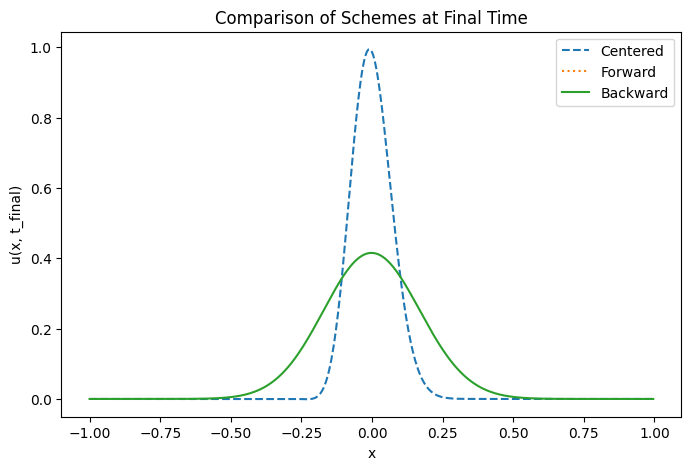

In [11]:
# --- Final states ---
u_c_final = u_c[-1]
u_f_final = u_f[-1]
u_b_final = u_b[-1]

# --- Plot final solutions ---
plt.figure(figsize=(8, 5))
plt.plot(x, u_c_final, label='Centered', linestyle='--')
plt.plot(x, u_f_final, label='Forward', linestyle=':')
plt.plot(x, u_b_final, label='Backward', linestyle='-')
plt.xlabel('x')
plt.ylabel('u(x, t_final)')
plt.title('Comparison of Schemes at Final Time')
plt.legend()
plt.show()

In [12]:
# --- Peak position (where max occurs) ---
def peak_position(u, x):
    return x[np.argmax(u)]

x_peak_c = peak_position(u_c_final, x)
x_peak_f = peak_position(u_f_final, x)
x_peak_b = peak_position(u_b_final, x)

print(f"Peak position (Centered): {x_peak_c:.15f}")
print(f"Peak position (Forward) : {x_peak_f:.15f}")
print(f"Peak position (Backward): {x_peak_b:.15f}")


Peak position (Centered): -0.008000000000000
Peak position (Forward) : -1.000000000000000
Peak position (Backward): 0.000000000000000
